# Molecular dynamics

## With OpenMM

```python
import openmm as mm
from openmm import unit
from uibcdf_systems import DoubleWell

molecular_system = DoubleWell(n_particles = 1, mass = 64 * unit.amu,
                              Eo=3.0 * unit.kilocalories_per_mole,
                              a=5.0 * unit.angstroms, b=0.0 * unit.kilocalories_per_mole,
                              k=1.0 * unit.kilocalories_per_mole/unit.angstrom**2)

integrator = mm.LangevinIntegrator(300.0*unit.kelvin, 1.0/unit.picoseconds, 0.1*unit.picoseconds)
platform = Platform.getPlatformByName('CUDA')
simulation = Simulation(molecular_system.topology, molecular_system.system, integrator, platform)

coordinates = np.zeros([1, 3], np.float32) * unit.nanometers
simulation.context.setPositions(coordinates)

velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
simulation.context.setVelocities(velocities)

simulation.step(1000)
```

## With this library

In [2]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from openmm import unit

from uibcdf_systems import DoubleWell
from uibcdf_systems.tools import langevin

molecular_system = DoubleWell(n_particles = 1, mass = 64 * unit.amu,
                              Eo=3.0 * unit.kilocalories_per_mole,
                              a=5.0 * unit.angstroms, b=0.0 * unit.kilocalories_per_mole,
                              k=1.0 * unit.kilocalories_per_mole/unit.angstrom**2)

### Newtonian dynamics


In [3]:
initial_positions = np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 0.55 * unit.nanometers

initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

molecular_system.set_coordinates(initial_positions)
molecular_system.set_velocities(initial_velocities)

traj_dict = langevin(molecular_system,
                     friction=0.0/unit.picoseconds,
                     temperature=00.0*unit.kelvin,
                     time=20.0*unit.picoseconds,
                     saving_timestep=0.1*unit.picoseconds,
                     integration_timestep=0.02*unit.picoseconds)

  0%|          | 0/1000 [00:00<?, ?it/s]

We can now plot the trajectory of the x coordinate:

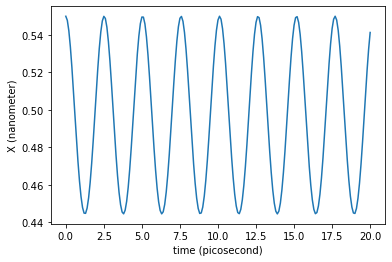

In [4]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

Now we can wonder, is the period of the oscillations is in agreement with the value calculated before? A shorter run with more points could be enough to say, by inspection, that the calculus is correct.

In [5]:
mass = 64 * unit.amu
Eo=3.0 * unit.kilocalories_per_mole
a=5.0 * unit.angstroms
T = 2*np.pi*np.sqrt((mass*a**2)/(8.0*Eo))

print('The period of the small oscillations around the minimum is',T)

The period of the small oscillations around the minimum is 2.5080627665032216 ps


As we can also check with the method:

In [6]:
molecular_system.get_small_oscillations_time_periods_around_minima()

([Quantity(value=array([-0.5,  0. ,  0. ]), unit=nanometer),
  Quantity(value=array([0.5, 0. , 0. ]), unit=nanometer)],
 [Quantity(value=array([2.50806277, 2.45738961, 2.45738961]), unit=picosecond),
  Quantity(value=array([2.50806277, 2.45738961, 2.45738961]), unit=picosecond)])

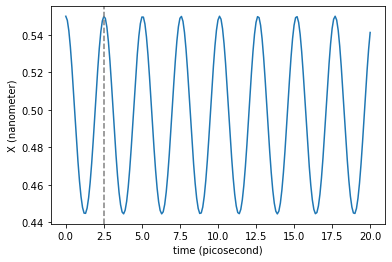

In [7]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.axvline(T._value, color='gray', linestyle='--') # Period of the harmonic oscillations approximation
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

It seems a good approximation to what is observed graphically in the integrated trajectory. Keep in mind that this is an approximation valid when the particle moves very close the bottom of the basins. In an real harmonic oscillator this period does not change with amplitude, but in this case does it. If the amplitude is large enough the oscillations are far from being well approximated by the cuadratic term of the Taylor expansion. Try to play with larger and shorter initial distances to the minimum to see this effect:

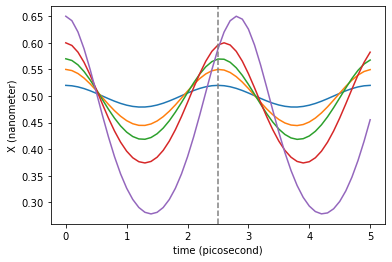

In [8]:
amplitudes = 0.5*unit.nanometers + np.array([0.02, 0.05, 0.07, 0.1, 0.15]) * unit.nanometers
traj_dicts = []

for amplitude in amplitudes:
    initial_positions[0,0] = amplitude
    molecular_system.set_coordinates(initial_positions)
    traj_dict = langevin(molecular_system,
                         friction=0.0/unit.picoseconds,
                         temperature=00.0*unit.kelvin,
                         time = 5*unit.picoseconds,
                         integration_timestep = 0.02 * unit.picoseconds,
                         saving_timestep = 0.1 * unit.picoseconds,
                         tqdm=False)
    traj_dicts.append(traj_dict)
    
for traj_dict in traj_dicts:
    plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])

plt.axvline(T._value, color='gray', linestyle='--') # Period of the harmonic oscillations approximation
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

The newtonian dynamics can also include damping. This way we can simulate damped oscillations around the minimum.

In [9]:
traj_dict = langevin(molecular_system,
                     friction=0.5/unit.picoseconds,
                     temperature=0.0*unit.kelvin,
                     time=20.0*unit.picoseconds,
                     saving_timestep=0.1*unit.picoseconds,
                     integration_timestep=0.02*unit.picoseconds)

  0%|          | 0/1000 [00:00<?, ?it/s]

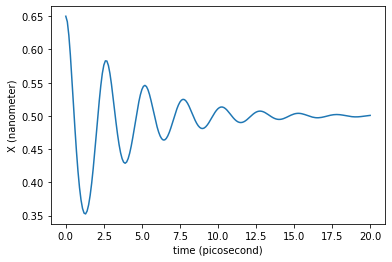

In [10]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

What would be the friction value needed to enter in the overdamped regime?

In [11]:
traj_dict = langevin(molecular_system,
                     friction=5.0/unit.picoseconds,
                     temperature=0.0*unit.kelvin,
                     time=20.0*unit.picoseconds,
                     saving_timestep=0.1*unit.picoseconds,
                     integration_timestep=0.02*unit.picoseconds)

  0%|          | 0/1000 [00:00<?, ?it/s]

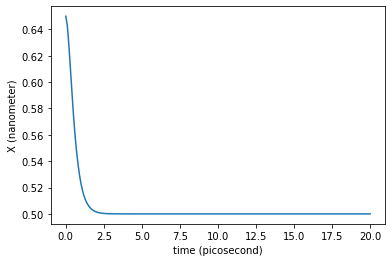

In [12]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

And the same can be checked for the asymmetric double well potential. In the case of the period of short oscillations around a minimum, keep in mind that there the minimum is not longer $a$, and $T$ was here calculated with the value of the second derivative (equal, no matter the value of $b$) in $a$. But still is a good approximation.

### Stochastic Dynamics

Thanks to the `tools.langevin` method in this library, a simple newtonian dynamics can be run with few effort:

In [13]:
initial_positions = np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 0.5 * unit.nanometers

initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

molecular_system.set_coordinates(initial_positions)
molecular_system.set_velocities(initial_velocities)

traj_dict = langevin(molecular_system,
                     friction=1.0/unit.picoseconds,
                     temperature=300.0*unit.kelvin,
                     time=10.0*unit.nanoseconds,
                     saving_timestep=1.0*unit.picoseconds,
                     integration_timestep=0.1*unit.picoseconds)

  0%|          | 0/100000 [00:00<?, ?it/s]

Let us see the time evolution of the coordinate $x$ of our single particle:

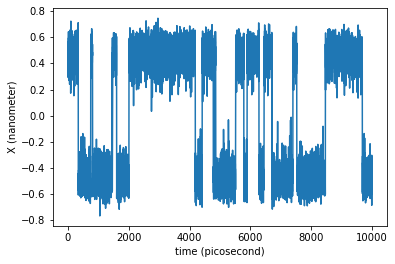

In [14]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

The trajectory is long enough to observe the system hopping on and off from the initial basin.